# Model 1 Error Analysis

In [1]:
import s3fs
import boto3
import pandas as pd
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')

import re
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ec2-user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import numpy as np
from copy import copy

## Get the Data

In [3]:
results_1000 = pd.read_csv('1000results_model1v2.csv')
train_1000_labeled = pd.read_csv('train_1000_labeled.csv') #labeled data

In [ ]:
results_1000['relationships_true'] = train_1000_labeled['relationships']

In [4]:
results_1000

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,index,Unnamed: 0,bookId,title,series,author,rating,...,Contains True?,tokens,university,relationships,break ups,divorce,weddings,family,friendship,death
0,0,0,0,0,"39,822",34838660-not-part-of-the-plan,Not Part of the Plan,Blue Moon #4,Lucy Score (Goodreads Author),4.46,...,1.0,"['wall', 'street', 'journal', 'amazon', 'bests...",False,False,False,False,False,True,True,False
1,1,1,1,1,"34,235",20176552-dragon-age-volume-1,"Dragon Age, Volume 1",Dragon Age Graphic Novels #1-3,"David Gaider, Chad Hardin (Illustrator), Antho...",4.26,...,0.0,"['helping', 'set', 'stage', 'biowares', 'hotly...",False,False,False,False,False,False,False,False
2,2,2,2,2,"27,904",124110.Dangerous_to_Know,Dangerous to Know,NaN,Barbara Taylor Bradford (Goodreads Author),3.73,...,1.0,"['sebastian', 'locke', 'fiftysixyearold', 'pat...",False,False,False,True,False,True,False,True
3,3,3,3,3,"10,515",1046450.The_Wheel_of_Fortune,The Wheel of Fortune,NaN,Susan Howatch,4.11,...,1.0,"['take', 'back', 'oxmoon', 'lost', 'paradise',...",False,False,False,False,False,True,False,False
4,4,4,4,4,935,872333.Blue_Bloods,Blue Bloods,Blue Bloods #1,Melissa de la Cruz (Goodreads Author),3.69,...,0.0,"['mayflower', 'set', 'sail', 'carried', 'board...",False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,995,995,995,"17,361",588326.The_Blue_Helmet,The Blue Helmet,NaN,William Bell,3.42,...,1.0,"['lee', 'wants', 'tarantula', 'member', 'bigge...",False,False,False,False,False,False,True,True
996,996,996,996,996,"9,029",93007.The_Merry_Adventures_of_Robin_Hood,The Merry Adventures of Robin Hood,NaN,Howard Pyle,4.07,...,0.0,"['merry', 'adventures', 'robin', 'hood', 'grea...",False,False,False,False,True,False,False,False
997,997,997,997,997,"32,216",1085376.Before_You_Sleep,Before You Sleep,NaN,"Linn Ullmann, Tiina Nunnally (Translator)",3.34,...,1.0,"['moving', 'presentday', 'oslo', 'brooklyn', '...",False,False,False,False,True,True,False,False
998,998,998,998,998,"1,036",28195.Inkspell,Inkspell,Inkworld #2,"Cornelia Funke (Goodreads Author), Anthea Bell...",3.91,...,0.0,"['captivating', 'sequel', 'inkheart', 'critica...",False,False,False,False,False,False,False,False


## Reformat Data

In [10]:
ZS_classifications

,relationships,friendship,weddings,family,break ups,university,death,divorce
0,True,True,False,False,False,False,False,False
1,True,False,True,False,False,True,False,False
2,True,False,True,True,False,True,False,False
3,True,False,False,True,True,False,True,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
995,False,True,True,False,False,False,False,False
996,False,False,False,False,False,False,False,False
997,True,False,False,True,False,False,False,False
998,True,True,True,True,False,True,False,False


## Evaluation Function

In [5]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

In [8]:
def eval_func(results, true_labels):
    LE_metrics = [] #returns confusion matrix and metrics for each life_event, need to add overall 
    eval_dict = {}
    metrics = {}
    for life_event in ['weddings', 'friendship', 'family', 'break ups', 'relationships', 'death', 'divorce', 'university']:
        cm = confusion_matrix(true_labels[life_event], results[life_event], labels=[False, True])
        TN, FP, FN, TP = cm.ravel()
        eval_dict['TN'] = copy(TN)
        eval_dict['TP'] = copy(TP)
        eval_dict['FN'] = copy(FN)
        eval_dict['FP'] = copy(FP)
        print(life_event.upper(), " Confusion Matrix")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        eval_dict['Recall or TPR'] = copy(TPR)
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        eval_dict['Specificity or TNR'] = copy(TNR)
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        eval_dict['Precision or PPV'] = copy(PPV)
        # Negative predictive value
        NPV = TN/(TN+FN)
        eval_dict['Negative Predictive Value'] = copy(NPV)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        eval_dict['False Positive Rate'] = copy(FPR)
        # False negative rate
        FNR = FN/(TP+FN)
        eval_dict['False Negative Rate'] = copy(FNR)
        # False discovery rate
        FDR = FP/(TP+FP)
        eval_dict['False Discovery Rate'] = copy(FDR)
        # Overall accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)
        eval_dict['Accuracy'] = copy(ACC)
        LE_metrics.append(copy(eval_dict))
    df = pd.DataFrame.from_records(LE_metrics, index = ['weddings', 'friendship', 'family', 'break ups', 'relationships', 'death', 'divorce', 'university'])
    return df

# Zero-shot Evaluation

WEDDINGS  Confusion Matrix


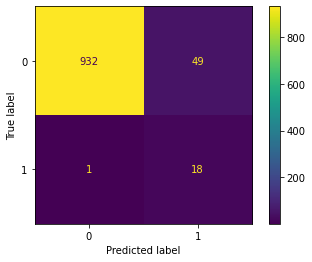

FRIENDSHIP  Confusion Matrix


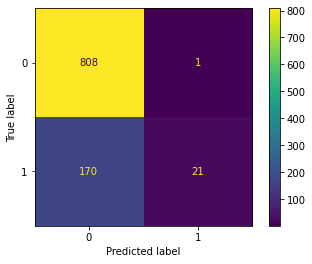

FAMILY  Confusion Matrix


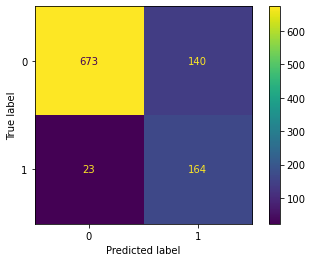

BREAK UPS  Confusion Matrix


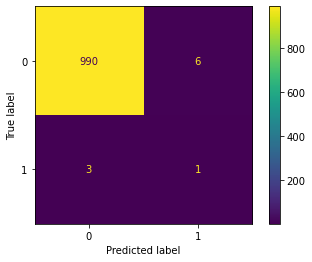

RELATIONSHIPS  Confusion Matrix


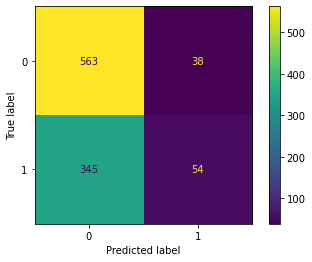

DEATH  Confusion Matrix


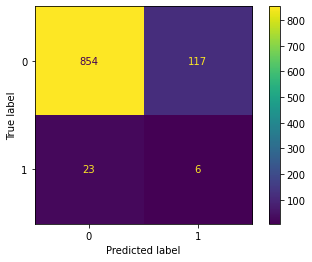

DIVORCE  Confusion Matrix


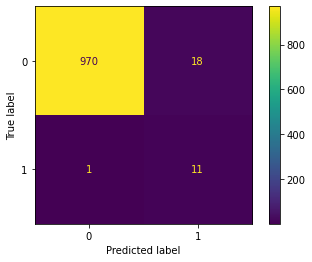

UNIVERSITY  Confusion Matrix


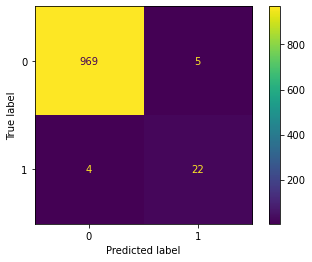

In [10]:
df = eval_func(results_1000, train_1000_labeled)

In [11]:
df

,TN,TP,FN,FP,Recall or TPR,Specificity or TNR,Precision or PPV,Negative Predictive Value,False Positive Rate,False Negative Rate,False Discovery Rate,Accuracy
weddings,932,18,1,49,0.947368,0.950051,0.268657,0.998928,0.049949,0.052632,0.731343,0.950
friendship,808,21,170,1,0.109948,0.998764,0.954545,0.826176,0.001236,0.890052,0.045455,0.829
family,673,164,23,140,0.877005,0.827798,0.539474,0.966954,0.172202,0.122995,0.460526,0.837
break ups,990,1,3,6,0.250000,0.993976,0.142857,0.996979,0.006024,0.750000,0.857143,0.991
relationships,563,54,345,38,0.135338,0.936772,0.586957,0.620044,0.063228,0.864662,0.413043,0.617
death,854,6,23,117,0.206897,0.879506,0.048780,0.973774,0.120494,0.793103,0.951220,0.860
divorce,970,11,1,18,0.916667,0.981781,0.379310,0.998970,0.018219,0.083333,0.620690,0.981
university,969,22,4,5,0.846154,0.994867,0.814815,0.995889,0.005133,0.153846,0.185185,0.991


In [12]:
df['TN'].sum()

6759

In [13]:
df['TP'].sum()

297

In [14]:
df['FP'].sum()

374

In [15]:
df['FN'].sum()

570

In [21]:
(df['TP'].sum() + df['TN'].sum()) / (df['TP'].sum() + df['TN'].sum() + df['FP'].sum() + df['FN'].sum())

0.882

In [16]:
170/570

0.2982456140350877

In [17]:
345/570

0.6052631578947368

In [18]:
140/374

0.37433155080213903

In [19]:
117/374

0.31283422459893045

In [20]:
49/374

0.13101604278074866

In [122]:
results_1000['death_true'] = train_1000_labeled['death']

In [123]:
EA_FP = results_1000.loc[(results_1000['death_true'] == False) & (results_1000['death'] == True)]

In [124]:
EA_TN = results_1000.loc[(results_1000['death_true'] == False) & (results_1000['death'] == False)]

In [85]:
EA_FP.columns

Index(['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'index', 'Unnamed: 0',
       'bookId', 'title', 'series', 'author', 'rating', 'description',
       'language', 'isbn', 'genres', 'characters', 'bookFormat', 'edition',
       'pages', 'publisher', 'publishDate', 'firstPublishDate', 'awards',
       'numRatings', 'ratingsByStars', 'likedPercent', 'setting', 'coverImg',
       'bbeScore', 'bbeVotes', 'price', 'Fiction', 'Nonfiction', 'Young Adult',
       'Childrens', 'New Adult', 'Fantasy', 'Erotica', 'History', 'Dystopia',
       'Poetry', 'Biography', 'Manga', 'Thriller', 'Graphic Novels', 'Romance',
       'labeled? ', 'Contains True?', 'tokens', 'university', 'relationships',
       'break ups', 'divorce', 'weddings', 'family', 'friendship', 'death',
       'relationships_true', 'friendship_true', 'family_true'],
      dtype='object')

In [125]:
from ast import literal_eval
EA_FP['tokens'] = EA_FP['tokens'].apply(lambda row: literal_eval(row))

/tmp/ipykernel_5430/3808028490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EA_FP['tokens'] = EA_FP['tokens'].apply(lambda row: literal_eval(row))


In [126]:
token_list = EA_FP['tokens'].sum()

In [127]:
TL = pd.DataFrame(token_list)

In [128]:
TL.value_counts()

death       128
life         70
one          68
new          55
world        55
           ... 
haunts        1
hausers       1
havers        1
hayworth      1
zone          1
Length: 5275, dtype: int64

In [112]:
EA_FP['genres'].value_counts()

['Fiction']                                                                                                                                            2
['Romance', 'Contemporary Romance', 'Contemporary', 'Humor', 'Fiction', 'Adult', 'Chick Lit', 'M F Romance', 'Family']                                 1
['Reverse Harem', 'Romance', 'Young Adult', 'Contemporary', 'High School', 'Mystery', 'Espionage', 'New Adult', 'Fiction', 'Young Adult Romance']      1
['Romance', 'Historical Romance', 'Historical Fiction', 'Regency', 'Historical', 'Regency Romance', 'Fiction', 'Adult', 'Chick Lit', 'Humor']          1
['Fiction', 'Westerns', 'Historical Fiction', 'Historical', '19th Century', 'Adult Fiction', 'Audiobook', 'Adventure', 'Literature', 'Novels']         1
                                                                                                                                                      ..
['Fiction', 'Thriller', 'Mystery', 'Suspense', 'Crime', 'Science Fiction', 'Advent

In [113]:
df_genres = EA_FP[['Young Adult', 'Childrens', 'New Adult', 'Fantasy', 'History', 'Dystopia', 'Manga', 'Thriller', 'Graphic Novels', 'Romance']]
df_genres.count()

Young Adult       52
Childrens         20
New Adult         11
Fantasy           57
History            0
Dystopia           3
Manga              0
Thriller          16
Graphic Novels     2
Romance           60
dtype: int64

In [114]:
genre_combos = df_genres.groupby(['Young Adult', 'Childrens', 'New Adult', 'Fantasy', 'History', 'Dystopia', 'Manga', 'Thriller', 'Graphic Novels', 'Romance'], dropna=False, as_index=False,).size().sort_values(by='size', axis=0, ascending=False)

In [115]:
genre_combos

,Young Adult,Childrens,New Adult,Fantasy,History,Dystopia,Manga,Thriller,Graphic Novels,Romance,size
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Romance,21
20,NaN,NaN,NaN,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,16
0,Young Adult,Childrens,NaN,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,12
8,Young Adult,NaN,NaN,Fantasy,NaN,NaN,NaN,NaN,NaN,Romance,10
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thriller,NaN,NaN,8
2,Young Adult,Childrens,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
19,NaN,NaN,NaN,Fantasy,NaN,NaN,NaN,NaN,NaN,Romance,7
5,Young Adult,NaN,New Adult,NaN,NaN,NaN,NaN,NaN,NaN,Romance,5
12,Young Adult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Romance,5


In [117]:
df_genres = EA_TN[['Young Adult', 'Childrens', 'New Adult', 'Fantasy', 'History', 'Dystopia', 'Manga', 'Thriller', 'Graphic Novels', 'Romance']]
df_genres.count()

Young Adult       231
Childrens          84
New Adult          36
Fantasy           306
History             2
Dystopia           43
Manga              10
Thriller           91
Graphic Novels     30
Romance           250
dtype: int64

In [118]:
genre_combos = df_genres.groupby(['Young Adult', 'Childrens', 'New Adult', 'Fantasy', 'History', 'Dystopia', 'Manga', 'Thriller', 'Graphic Novels', 'Romance'], dropna=False, as_index=False,).size().sort_values(by='size', axis=0, ascending=False)

In [119]:
genre_combos

,Young Adult,Childrens,New Adult,Fantasy,History,Dystopia,Manga,Thriller,Graphic Novels,Romance,size
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127
49,NaN,NaN,NaN,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,67
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Romance,66
24,Young Adult,NaN,NaN,Fantasy,NaN,NaN,NaN,NaN,NaN,Romance,55
58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thriller,NaN,NaN,52
...,...,...,...,...,...,...,...,...,...,...,...
27,Young Adult,NaN,NaN,NaN,NaN,Dystopia,NaN,NaN,NaN,Romance,1
28,Young Adult,NaN,NaN,NaN,NaN,NaN,Manga,NaN,Graphic Novels,Romance,1
29,Young Adult,NaN,NaN,NaN,NaN,NaN,Manga,NaN,Graphic Novels,NaN,1
30,Young Adult,NaN,NaN,NaN,NaN,NaN,NaN,Thriller,NaN,Romance,1


In [129]:
from ast import literal_eval
EA_TN['tokens'] = EA_TN['tokens'].apply(lambda row: literal_eval(row))
token_list = EA_TN['tokens'].sum()

/tmp/ipykernel_5430/1909391754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EA_TN['tokens'] = EA_TN['tokens'].apply(lambda row: literal_eval(row))


In [130]:
TL = pd.DataFrame(token_list)
TL.value_counts()[0:10]

one       433
new       402
life      372
world     299
love      224
story     207
first     185
family    179
find      169
time      157
dtype: int64